## Intent Classification With PyTorch
Previously, my focus in the notebooks was on obtaining labeled data for my chatbot. However, this current notebook is centered around utilizing PyTorch for the classification of intents within fresh, unseen user-generated data. The model has transitioned to a supervised learning approach, leveraging the labels derived from the unsupervised learning conducted in the preceding notebook.

### RASA Comparison

Rasa trains this intent classification step with SVM and GridsearchCV because they can try different configurations ([source](https://medium.com/bhavaniravi/intent-classification-demystifying-rasanlu-part-4-685fc02f5c1d)). When deploying preprocessing pipeline should remain same between train and test.

In [42]:
!pip3 install wandb


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import spacy 
import wandb
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [97]:
# Standard 
import collections
import yaml
import re
import os

# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Machine Learning
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# Deep Learning
import torch
from torch import nn
import torch.optim as optim

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Preprocessing and Torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# from torchtext.data import get_tokenizer

# Reading in training data
train = pd.read_pickle('../objects/train.pkl')
print(f'Training data: {train.head()}')

Pandas: 2.2.2
Numpy: 1.26.4
Sklearn: 1.4.2
Training data:                                              support  \
0  [very, poor, feedback, very, disappointing, se...   
1  [already, done, i, am, frankly, fed, up, with,...   
2  [very, poor, feedback, very, disappointing, se...   
3  [can, see, you, have, replied, to, others, who...   
4  [my, issue, is, not, resolved, really, should,...   

                                         account           greeting  \
0                      [email, account, details]               [hi]   
1                      [email, account, details]            [hello]   
2                      [email, account, details]     [what, is, up]   
3  [the, credit, card, information, is, correct]    [good, morning]   
4                        [account, email, email]  [good, afternoon]   

     goodbye                      speak_representative  \
0  [goodbye]                     [talk, human, please]   
1      [bye]              [let, me, talk, to, support]   
2   

In [164]:
!wandb login

wandb: Currently logged in as: sinhasagar507. Use `wandb login --relogin` to force relogin


In [4]:
# Configuration for training
# Change all of the following configurations as per the specifications in the original repo 
# Set a seed value 
seed_value = 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

In [5]:
train = pd.melt(train)
train.columns = ["intent", "tokens"]

In [6]:
shuffled_df = train.sample(frac=1).reset_index(drop=True)
shuffled_df 

,intent,tokens
0,discount,"[sale, discount]"
1,discount,"[special, offer, discount]"
2,account,"[delayed, orders, in, the, last, weeks, also, ..."
3,challenge_robot,"[is, this, an, automated, assistant]"
4,discount,"[as, i, purchased, a, product, from, amazon, o..."
...,...,...
8995,account,"[customer, service, tell, me, i, need, to, use..."
8996,speak_representative,"[can, i, get, a, live, representative]"
8997,speak_representative,"[can, you, put, me, through, to, a, representa..."
8998,track,"[track, my, order, status]"


In [7]:
train["tokens"]

0       [very, poor, feedback, very, disappointing, se...
1       [already, done, i, am, frankly, fed, up, with,...
2       [very, poor, feedback, very, disappointing, se...
3       [can, see, you, have, replied, to, others, who...
4       [my, issue, is, not, resolved, really, should,...
                              ...                        
8995    [prime, member, bought, prime, products, deliv...
8996    [m, not, interested, in, email, replies, do, l...
8997                             [really, disappointment]
8998                           [mrp, rs, selling, at, rs]
8999    [bought, a, lenovo, z, delivered, on, th, nove...
Name: tokens, Length: 9000, dtype: object

In [169]:
train["tokens"][0]

['very', 'poor', 'feedback', 'very', 'disappointing', 'services']

In [8]:
import ast
import string 

In [9]:
# List of common stopwords
manual_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
}



def basic_preprocess_tokens(tokens):
    
    # Convert string representation of list to actual list
    # tokens = ast.literal_eval(tokens)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in manual_stopwords]
    
    return tokens

# Apply basic preprocessing to the tokens column
shuffled_df['cleaned_tokens'] = shuffled_df['tokens'].apply(basic_preprocess_tokens)

shuffled_df.head()


,intent,tokens,cleaned_tokens
0,discount,"[sale, discount]",[sale discount]
1,discount,"[special, offer, discount]",[special offer discount]
2,account,"[delayed, orders, in, the, last, weeks, also, ...","[delayed, orders, last, weeks, also, pkg, deli..."
3,challenge_robot,"[is, this, an, automated, assistant]","[automated, assistant]"
4,discount,"[as, i, purchased, a, product, from, amazon, o...","[purchased, product, amazon, th, oct, purchasi..."


In [172]:
shuffled_df['cleaned_tokens'][100]

['customer',
 'care',
 'amazon',
 'india',
 'unprofessional',
 'use',
 'return',
 'pick',
 'may',
 'problem',
 'blue',
 'dart',
 'nobody',
 'interested',
 'go',
 'thru',
 'fb',
 'page',
 'huge',
 'complain',
 'careful',
 'deal',
 'amazon',
 'expecting',
 'mnc',
 'sorry',
 'state',
 'pl',
 'go',
 'indepth']

<Axes: ylabel='Count'>

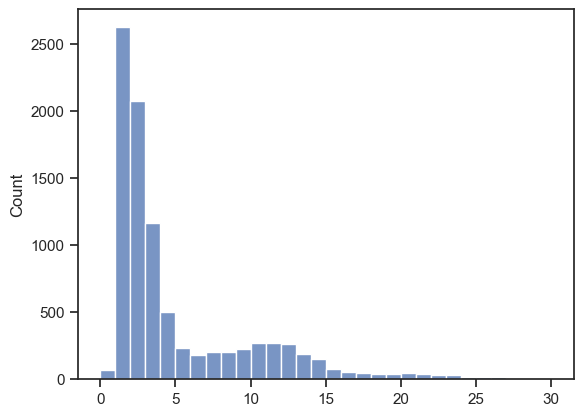

In [10]:
seq_lens = [len(tokens) for tokens in shuffled_df['cleaned_tokens']]
sns.histplot(seq_lens, bins=30)

In [11]:
shuffled_df.to_csv("../data/processed/train_intents.csv", index=False)

In [12]:
# Print the data types of the columns
print(shuffled_df.dtypes)

# Check the data types of each row in the "tokens" column and if its not a list, highlight the the error 
# Don't print it, log it 
print(" ")
for index, row in shuffled_df.iterrows():
    if not isinstance(row["tokens"], list):
        print(f"Error: {row['tokens']}")

intent            object
tokens            object
cleaned_tokens    object
dtype: object
 


In [68]:
X = [token_lst for token_lst in shuffled_df['cleaned_tokens']]
X = [*X]
y = [*shuffled_df['intent'].values]

In [69]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saggysimmba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saggysimmba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Torchtext Preprocessing

### Torchtext tokenizer 
- Add description later 

### Plan of Action
- Prepare the dataset 

In [10]:
%pwd

'/Applications/saggydev/projects_learning/amazon_support/notebooks'

- Steps taken
    -   the words would involve creating a vocabulary dictionary to map words to indices 
    -   For each sequence, the words are converted into their corresponding indices based on the word dictionary 
    - When feeding sentences into the model, ensure a consistent sequence length is crucial 
    - To achieve this, sequences are padded with zeros until they reach the length of the longest sequence 
    - This padding ensures uniformity, and shorter maximum lengths are typically preferred for ease of training, as longer sequences can pose challenges 
    - This padding ensures uniformity, and shorter maximum lengths are typically preferred for ease of training, as longer sequences can pose challenges 


In [23]:
# Use glove word embeddings 
embeddings_index = {}
f = open("../models/glove.twitter.27B/glove.twitter.27B.200d.txt", "r", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [70]:
# Now build a vocabulary: This is something I hadve just added 
from collections import Counter
word_counts = Counter(token for sentence in X for token in sentence)
vocabulary = {word: i+1 for i, (word, _) in enumerate(word_counts.items())}  # Reserve 0 for padding 
vocabulary["<UNK>"] = len(vocabulary) + 1  # Reserve for unknown words

In [79]:
# Create an embedding matrix
embedding_dim = 200
vocab_size = len(vocabulary) + 1  # +1 for unknown token 

# Option for <UNK> embedding: Average of all embeddings
#unk_embedding = np.mean(list(embeddings_index.values()), axis=0)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [83]:
# Encocde sentences as sequences of integers: This is something I have just added
def encode_sequences(tokenized_sentences, vocab):
    sequences = []
    for sentence in tokenized_sentences:
        sequence = [vocab.get(word, 0) for word in sentence]  # 0 for unknown words
        sequences.append(sequence)
    return sequences

In [84]:
X = encode_sequences(X, vocabulary)

In [85]:
from sklearn.model_selection import train_test_split

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset into stratified train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, shuffle=True, random_state=seed_value)

In [86]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert the target variable to a tensor
X_train_tensors = [torch.tensor(sequence, dtype=torch.long) for sequence in X_train]
X_val_tensors = [torch.tensor(sequence, dtype=torch.long) for sequence in X_val]

# Pad the sequences
X_train_tensor = pad_sequence(X_train_tensors, batch_first=True)
X_val_tensor = pad_sequence(X_val_tensors, batch_first=True)

In [110]:
X_train_tensor.shape, X_val_tensor.shape

(torch.Size([7200, 30]), torch.Size([1800, 30]))

In [ ]:
# def re_pad_sequences(tensor, fixed_length):
#     # Calculate the difference in length
#     length_diff = fixed_length - tensor.shape[1]
    
#     if length_diff > 0:
#         # If the tensor is shorter, pad it
#         padding = torch.zeros((tensor.shape[0], length_diff), dtype=tensor.dtype)
#         padded_tensor = torch.cat([tensor, padding], dim=1)
#     elif length_diff < 0:
#         # If the tensor is longer, truncate it
#         padded_tensor = tensor[:, :fixed_length]
#     else:
#         # If the tensor is already at the desired length, do nothing
#         padded_tensor = tensor
    
#     return padded_tensor

In [101]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [87]:
from torch import LongTensor
train_seq_lengths = LongTensor(list(map(len, X_train_tensors)))
val_seq_lengths = LongTensor(list(map(len, X_val_tensors)))

In [95]:
# Sort sequences by lengths in descending order (if not already sorted)
X_train_sorted, train_lengths_sorted = X_train_tensor[train_seq_lengths.sort(descending=True)[1]], train_seq_lengths[train_seq_lengths.sort(descending=True)[1]]
X_val_sorted, val_lengths_sorted = X_val_tensor[val_seq_lengths.sort(descending=True)[1]], val_seq_lengths[val_seq_lengths.sort(descending=True)[1]]

In [100]:
# Pack the padded sequences 
# X_train_packed = pack_padded_sequence(X_train_sorted, train_lengths_sorted, batch_first=True, enforce_sorted=False)
# X_val_packed = pack_padded_sequence(X_val_sorted, val_lengths_sorted, batch_first=True, enforce_sorted=True)

In [231]:
# def collate_fn(batch):
#     sequences, labels = zip(*batch)
#     lengths = torch.tensor([len(seq) for seq in sequences])
#     padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
#     labels = torch.tensor(labels)
#     return padded_sequences, labels, lengths

In [102]:
# Create train and test datasets
# train_dataset = Subset(TensorDataset(X_tensor, y_tensor), train_indices)
# test_dataset = Subset(TensorDataset(X_tensor, y_tensor), val_indices)

# DataLoader for train and test datasets
train_dataloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)


In [225]:
# Assuming 'train' is a DataFrame containing 'Utterance' and 'Intent' columns

# Tokenize the text data using PyTorch's tokenizer
# The text already seems to be tokenized 

# Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
#                                                   shuffle=True, stratify=y, random_state=seed_value)

# # Label encode the target variable
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)


# # Convert encoded targets to PyTorch tensors
# y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long) 
# y_val_encoded = torch.tensor(y_val_encoded, dtype=torch.long)

# print(f'\nShape checks:\nX_train: {len(X_train)} X_val: {len(X_val)}\ny_train: {len(y_train_encoded)} y_val: {len(y_val_encoded)}')

In [131]:
# encoded_X_train = encode_sequences(X_train, vocabulary)
# encoded_X_val = encode_sequences(X_val, vocabulary)

In [68]:
# Pad sequences to a fixed length: This is something I have just added

# Convert encoded sequences to PyTorch tensors
# encoded_X_train_tensors = [torch.tensor(seq) for seq in encoded_X_train]
# encoded_X_val_tensors = [torch.tensor(seq) for seq in encoded_X_val]

# Pad sequences
# Set batch_first=True to have the batch dimension first
# padded_X_train = pad_sequence(encoded_X_train_tensors, batch_first=True, padding_value=0)
# padded_X_val = pad_sequence(encoded_X_val_tensors, batch_first=True, padding_value=0)

In [226]:
# ## Custom collate function to pad sequences 
# def collate_fn(batch):
#     sequences, labels = zip(*batch)
#     lengths = torch.tensor([len(seq) for seq in sequences])
#     padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
#     labels = torch.tensor(labels)
#     return padded_sequences, lengths, labels

In [227]:
# Just an experimental check
from torch.nn import Embedding  
# embedding_layer = Embedding(num_embeddings=embedding_matrix_tensor.size(0), 
#                             embedding_dim=embedding_matrix_tensor.size(1), 
#                             _weight=embedding_matrix_tensor)

# # Freeze the embedding layer
# embedding_layer.weight.requires_grad = False

In [228]:
# Assuming padded_X_train and padded_X_val are NumPy arrays
# padded_X_train_tensor = torch.LongTensor(padded_X_train)
# padded_X_val_tensor = torch.LongTensor(padded_X_val)

In [72]:
# padded_X_train_tensor.shape

torch.Size([12600, 32])

In [229]:
# padded_X_val_tensor.shape

In [74]:
# Repad the data
# Assuming you've decided on a fixed sequence length, for example, the max length found in the training set
# fixed_seq_length = 32

# Function to re-pad tensors to a fixed length


In [75]:
# seq_len = padded_X_train_tensor.shape[1]

In [230]:
# Re-pad both the training and validation tensors
# padded_X_train_tensor = re_pad_sequences(padded_X_train_tensor, fixed_seq_length)
# padded_X_val_tensor = re_pad_sequences(padded_X_val_tensor, fixed_seq_length)

# Now both tensors should have the same shape in terms of sequence length
# print(padded_X_train_tensor.shape)
# print(padded_X_val_tensor.shape)

In [103]:
# Embedding layer
embedding_matrix_tensor = torch.FloatTensor(embedding_matrix)
embedding = nn.Embedding(vocab_size, embedding_dim)
embedding.weight = nn.Parameter(embedding_matrix_tensor)
embedding.weight.requires_grad = False  # To not train the embedding layer

In [104]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="intent-classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "epochs": 30,
    "batch_size": 32, 
    "embedding_size": 200,
    "hidden_size": 256,
    "output_size": 9,
    "num_layers": 3,
   # "dropout": 0.1,
    "eval_metric": "accuracy", 
    # "weight_decay": 1e-6,
    "scheduler_lambda_epoch_threshold": 10,
    "scheduler_decay_rate": -0.1
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sinhasagar507. Use `wandb login --relogin` to force relogin


In [26]:
# Define the sweep config 
# sweep_config = {
#     "method": "random",
#     "metric": {"goal": "maximize", "name": "val_accuracy"}, 
#     "parameters": {
#                     "learning_rate": {"values": [0.01, 0.001, 0.0001]},
#                     "epochs": {"values": [30]},
#                     "batch_size": {"values": [32, 64, 128]},
#                     "embedding_size": {"values": [100]},
#                     "hidden_size": {"values": [64, 128, 256]},
#                     "output_size": {"values": [9]},
#                     "num_layers": {"values": [1, 2, 3]},
#                     "dropout": {"values": [0.1, 0.2, 0.3]}, 
#                     "weight_decay": {"values": [1e-3, 1e-4, 1e-5]},
#                     "scheduler_lambda_epoch_threshold": {"values": [10]},
#                     "scheduler_decay_rate": {"values": [-0.1]},
#                 }
# }

# sweep_defaults = {
#     "learning_rate": 0.001,
#     "epochs": 30,
#     "batch_size": 16, 
#     "embedding_size": 100,
#     "hidden_size": 128,
#     "output_size": 9,
#     "num_layers": 3,
#     "dropout": 0.05,
#     "eval_metric": "accuracy", 
#     "weight_decay": 1e-3,
#     "scheduler_lambda_epoch_threshold": 10,
#     "scheduler_decay_rate": -0.1
# }

# sweep_id = wandb.sweep(sweep_config, project="intent-classification")

In [105]:
class MODEL_EVAL_METRIC:
    accuracy = "accuracy"
    f1_score = "f1_score"
    
class Config: 
    VOCAB_SIZE = 0
    BATCH_SIZE = 32 
    EMB_SIZE = 300 
    OUT_SIZE = 9 # Corresponds to the number of intents
    NUM_FOLDS = 5 
    NUM_EPOCHS = 5
    NUM_WORKERS = 8
    
    # I want to update the pretrainhttps://wandb.ai/sinhasagar507/intent-classification/sweeps/4sd3drrded embedding weights during training process 
    # I want to use a pretrained embedding
    OPTIMIZER = "Adam"
    EMB_WT_UPDATE = True
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    MODEL_EVAL_METRIC = MODEL_EVAL_METRIC.accuracy
    FAST_DEV_RUN = False 
    PATIENCE = 6 
    IS_BIDIRECTIONAL = True 
    
     
    # Model hyperparameters
    MODEL_PARAMS = {
        "hidden_size": 128,
        "num_layers": 2,
        "drop_out": 0.4258,
        "lr": 0.000366,
        "weight_decay": 0.00001
    }

In [28]:
# Just an experimental check
# from torch.nn import Embedding  
# embedding_layer = Embedding(num_embeddings=embedding_matrix_tensor.size(0), 
#                             embedding_dim=embedding_matrix_tensor.size(1), 
#                             _weight=embedding_matrix_tensor)

In [107]:
# Enhance the architecture later 
class IntentClassifier(nn.Module):
    
    def __init__(self, seq_len, embedding_matrix): 
        super().__init__()

        # Embedding layer
        self.embedding_dim = wandb.config["embedding_size"]
        embedding_matrix_tensor = torch.FloatTensor(embedding_matrix)
        self.embedding = nn.Embedding(seq_len, self.embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix_tensor)
        self.embedding.weight.requires_grad = False  # To not train the embedding layer
        
        # LSTM layer
        self.hidden_dim = wandb.config["hidden_size"]
        self.num_layers = wandb.config["num_layers"]
       # self.dropout = wandb.config["dropout"]
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.num_layers, 
                            bidirectional=True, 
                          #  dropout=self.dropout, 
                            batch_first=True)
        
        # The output of this operation should be 
        
        # Dense layers 

        self.fc1 = nn.Linear(self.hidden_dim*2, 1024)  # 2 for bidirectional. Over here, its (128*2) = 256, 1024 is the output dimension of the first dense layer
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 256) 
        
        # Dropout layer
       # self.dropout = nn.Dropout(self.dropout)  
        
        # Output layer
        self.output_dim = wandb.config["output_size"]
        self.out = nn.Linear(256, self.output_dim) ## Yaar idhr output hoga RNN ya LSTM ka (batch_size output_dim, no_of_classes) aayega kya? 
        # self.out_2 = nn.Linear(output_dim, 9)
        
    def forward(self, inputs):
        
        # text = [batch_size, embed_length]
        
        # embeddings = self.dropout(self.embedding(inputs))
        
        # embedded = [batch_size, sent_length, emb_dim]

        # if self.embedding_matrix is not None: 
        #     assert self.embeddings.shape == (inputs.shape[0], inputs.shape[1], self.embedding_dim)
         
        # pack_padded_sequence before feeding to the LSTM. This is required so PyTorch knows 
        # which elements of the sequence are padded and ignores them in the computation 
        # Accomplished only after the embedding step 
        # embeds_pack = pack_padded_sequence(embeddings, inputs_lengths, batch_first=True)
        
        # Get the dimensions of the packed sequence 
        # dimensions = embeds_pack.data.size()

        # Assert the shape of input sequence 
        # assert inputs.shape == (Config.BATCH_SIZE, 1000)

        embeddings = self.embedding(inputs)
        # print(f"Embeddings shape: {embeddings.shape}")
        _, (hidden, _) = self.lstm(embeddings)

        # hidden shape: [num_layers*num_directions, batch_size, hidden_dim]
        # print(f"Hidden shape: {hidden.shape}
        
        # Ours task being a classification model, we are only interested in the final hidden state and not the LSTM output 
        # h_n and c_n = [num_directions * num_layers, batch_size, hidden_size]
        final_hidden_forward = hidden[-2, :, :] # [batch_size, hidden_dim]
        final_hidden_backward = hidden[-1, :, :] # [bacth_size, hidden_dim]

        # print(f"Final hidden forward shape: {final_hidden_forward.shape}") # Iska shape is 
        # print(f"Final hidden backward shape: {final_hidden_backward.shape}")
        
        # Concat the final forward and hidden backward states 
        hidden = torch.cat((final_hidden_forward, final_hidden_backward), dim=1)
        # print(f"Hidden shape after concatenation: {hidden.shape}")
                
        # Dense Linear Layers 
        dense_outputs_1 = self.fc1(hidden)
        dense_outputs_1 = nn.ReLU()(dense_outputs_1)  
        dense_outputs_2 = self.fc2(dense_outputs_1)
     #   dense_outputs_2 = self.dropout(dense_outputs_2)
        dense_outputs_2 = nn.ReLU()(dense_outputs_2) 
        dense_outputs_3 = self.fc3(dense_outputs_2)
        dense_outputs_3 = nn.ReLU()(dense_outputs_3)
     #  dense_outputs_3 = self.dropout(dense_outputs_3)

        # Final output classification layer
        # Applying the Softmax layer 
        final_output = (self.out(dense_outputs_3))
        # print(f"Final output shape: {final_output.shape}")
    
        return final_output

In [108]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class ModelTrainer:
    def __init__(self, seq_len):
        self.seq_len = seq_len
        self.embedding_dim = wandb.config["embedding_size"]
        self.embedding_matrix = embedding_matrix   
        self.hidden_dim = wandb.config["hidden_size"]
        self.output_dim = wandb.config["output_size"]
        self.n_layers = wandb.config["num_layers"]
        self.batch_size = wandb.config["batch_size"]
        self.epochs = wandb.config["epochs"]
     #   self.dropout = wandb.config["dropout"]
        # Assuming IntentClassifier is defined elsewhere and matches these parameters
        # print(self.seq_len, self.embedding_dim, self.hidden_dim, self.output_dim, self.embedding_matrix)
        self.model = IntentClassifier(self.seq_len, self.embedding_matrix)
        self.criterion = nn.CrossEntropyLoss()
        # Assuming Config.OPTIMIZER is a valid PyTorch optimizer class
        self.learning_rate = wandb.config["learning_rate"]
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler_epoch_threshold = wandb.config["scheduler_lambda_epoch_threshold"]
        self.scheduler_decay_rate = wandb.config["scheduler_decay_rate"]
        self.epoch_lst = []

    def train(self, train_dataloader, val_dataloader):
        #TODO: Change the function format afterwards 
        # X_train = torch.tensor(X_train, dtype=torch.float)
        # X_val = torch.tensor(X_val, dtype=torch.float)
        # y_train = torch.tensor(y_train, dtype=torch.long)
        # y_val = torch.tensor(y_val, dtype=torch.long)

        # Assuming X_train, y_train, X_val, y_val are already tensors
        # Ensure they have matching first dimensions
        # assert X_train.shape[0] == y_train.shape[0], "Training feature and label count mismatch"
        # assert X_val.shape[0] == y_val.shape[0], "Validation feature and label count mismatch"
        
       
        train_accuracies_epoch, val_accuracies_epoch = [], []
        self.valid_loss_min = np.Inf

        # Assuming `optimizer` is already defined
        # Define the lambda function for learning rate adjustment using W&B config
        # lambda_lr = lambda epoch: 1 if epoch < self.scheduler_epoch_threshold else torch.exp(torch.tensor(-self.scheduler_decay_rate))

        # Initialize the LambdaLR scheduler with the optimizer and lambda function
        # scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda_lr)


        for epoch in range(self.epochs):
            train_loss, valid_loss = 0.0, 0.0
            correct, total = 0, 0

            self.model.train()
            for data, target in train_dataloader:
                # Log the shape of the data and target tensors
                # assert data.shape == (self.batch_size, self.embedding_dim), f"Data shape mismatch: {data.shape}"
                # assert target.shape == (self.batch_size,), f"Target shape mismatch: {target.shape}"
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

                # print(output.shape)
                pred_labels = torch.argmax(output, 1)
                correct += (pred_labels == target).sum().item()
                total += target.size(0)
                train_loss += loss.item() * data.size(0)


            train_accuracy = 100 * correct / total
            train_accuracies_epoch.append(train_accuracy)

            # Log the training loss and accuracy
            # wandb.log({"Training Accuracy": train_accuracy, "Training Loss": train_loss})

            self.model.eval()
            correct, total = 0, 0
            for data, target in val_dataloader:
                output = self.model(data)
                loss = self.criterion(output, target)

                pred_labels = torch.argmax(output, 1)
                correct += (pred_labels == target).sum().item()
                total += target.size(0)
                valid_loss += loss.item() * data.size(0)

            valid_accuracy = 100 * correct / total
            val_accuracies_epoch.append(valid_accuracy)

            # Log the validation loss and accuracy
            # print(f"Epoch: {epoch+1}/{self.epochs}.. Training Accuracy: {train_accuracy:.3f}.. Validation Accuracy: {valid_accuracy:.3f}")

            # Log epoch-wise accuracies
            wandb.log({"epoch": epoch, "Training Accuracy": train_accuracy, "Validation Accuracy": valid_accuracy, "Training Loss": train_loss, "Validation Loss": valid_loss})

            if valid_loss <= self.valid_loss_min:
                print(f"Validation loss decreased ({self.valid_loss_min:.3f} --> {valid_loss:.3f}). Saving model...")
                
                # Log the model and its parameters 
                # wandb.log_artifact(self.model)
                state = {
                    "epoch": epoch,
                    "state_dict": self.model.state_dict(),
                    "optimizer": self.optimizer.state_dict(),
                    "loss": valid_loss
                }
                torch.save(state, "../models/intent_classification_model.pt")
                self.valid_loss_min = valid_loss

            self.epoch_lst.append(epoch + 1)

Things I Need to Add
- WandB table
- Log artifact (model)
- For now, include all the basic elements (then we can improve upon this in the future)
- Ability to track across multiple hyperparameters
- Set the configuration after the run is complete
- Sweeps (...) AND Improvisation

In [27]:
# Train the model
# trainer = ModelTrainer(padded_X_train.shape[1])
# train_features, val_features = padded_X_train, padded_X_val
# trainer.train(train_features, y_train_encoded, val_features, y_val_encoded)

### The dataset needs extensive cleaning 

In [113]:
# Train the model
seq_len = 30
trainer = ModelTrainer(seq_len)
trainer.train(train_dataloader, val_dataloader)

Validation loss decreased (inf --> 2016.308). Saving model...
Validation loss decreased (2016.308 --> 1574.185). Saving model...
Validation loss decreased (1574.185 --> 1405.929). Saving model...
Validation loss decreased (1405.929 --> 1375.049). Saving model...
Validation loss decreased (1375.049 --> 1346.075). Saving model...
Validation loss decreased (1346.075 --> 1245.105). Saving model...
Validation loss decreased (1245.105 --> 1213.583). Saving model...
Validation loss decreased (1213.583 --> 1206.395). Saving model...
Validation loss decreased (1206.395 --> 1155.383). Saving model...
Validation loss decreased (1155.383 --> 1134.614). Saving model...


In [83]:
# Step 3: Define the Training Function
# def train():
#     # Initialize a new wandb run
#     wandb.init(config=sweep_defaults)
    
#     # Modify the trainer initialization and training process to use config parameters
#     trainer = ModelTrainer(padded_X_train.shape[1])
#     train_features, val_features = padded_X_train, padded_X_val
    
#     # Assuming the trainer.train method is modified to accept epochs and batch_size
#     trainer.train(train_features, y_train_encoded, val_features, y_val_encoded)
        
# # Step 4: Start the Sweep Agent
# wandb.agent(sweep_id, train)

In [107]:
def load_checkpoint(model, optimizer, filename='../models/intent_classification_model.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 15
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['loss']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [108]:
model = IntentClassifier(seq_len, embedding_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model, optimizer, start_epoch, losslogger = load_checkpoint(model, optimizer)

=> loading checkpoint '../models/intent_classification_model.pt'
=> loaded checkpoint '../models/intent_classification_model.pt' (epoch 13)


In [109]:
# Continue training the model
model_trainer = ModelTrainer(seq_len)
model_trainer.train(padded_X_train_tensor, y_train_encoded, padded_X_val_tensor, y_val_encoded, model)

Validation loss decreased (inf --> 5181.697). Saving model...


KeyboardInterrupt: 

In [243]:
padded_X_train_tensor

tensor([[ 616,  410,    0,  ...,    0,    0,    0],
        [1449,    0,    0,  ...,    0,    0,    0],
        [ 191,  833,  122,  ...,    0,    0,    0],
        ...,
        [1056,    0,    0,  ...,    0,    0,    0],
        [1272,    0,    0,  ...,    0,    0,    0],
        [ 115,    0,    0,  ...,    0,    0,    0]])

### Plot the data and related information 

In [40]:
wandb.config

{'learning_rate': 0.01, 'epochs': 30, 'batch_size': 64, 'embedding_size': 100, 'hidden_size': 256, 'output_size': 9, 'num_layers': 3, 'dropout': 0.3, 'eval_metric': 'accuracy', 'scheduler_lambda_epoch_threshold': 10, 'scheduler_decay_rate': -0.1}

In [84]:
# Load the trained model
model = IntentClassifier(seq_len, embedding_matrix)
model.load_state_dict(torch.load("../models/intent_classification_model.pt"))
model.eval()

def inference(text):
    """
    Perform preprocessing and inference on the input text using the trained model.
    
    Parameters:
    - model: The trained PyTorch model for intent classification.
    - text: The input text string.
    - vocabulary: A dictionary mapping tokens to indices.
    - seq_len: The fixed sequence length expected by the model.
    
    Returns:
    - pred_label: The predicted label index.
    """
    # Preprocess the text
    tokens = text.split()
    indices = [vocabulary.get(token, 0) for token in tokens]  # Use 0 for unknown words
    padded_indices = indices[:seq_len] + [0] * max(0, seq_len - len(indices))  # Pad with zeros
    input_tensor = torch.tensor(padded_indices).unsqueeze(0)  # Add batch dimension
    print(input_tensor.shape)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        pred_label = output
    
    return pred_label

TypeError: IntentClassifier.__init__() takes 3 positional arguments but 6 were given

In [87]:
inference("I want to book a flight")

torch.Size([1, 61])


tensor([[-1.4125, -3.6488, -1.7868, -3.2215, -5.8661,  1.0337, -4.6215, -0.6400,
         -0.6101]])

In [76]:
original_label = label_encoder.inverse_transform([5])
original_label

array(['quality'], dtype='<U20')